# Netflix Movie Recommendations
<img src='https://i.imgur.com/lM3fDZR.jpg' width='800' height='400'>

<h1>1. Business Problem </h1>

<h2> 1.1 Problem Description </h2>

<p>
Netflix is all about connecting people to the movies they love. To help customers find those movies, they developed world-class movie recommendation system: CinematchSM. Its job is to predict whether someone will enjoy a movie based on how much they liked or disliked other movies. Netflix use those predictions to make personal movie recommendations based on each customer’s unique tastes. And while <b>Cinematch</b> is doing pretty well, it can always be made better.
</p>
<p>Now there are a lot of interesting alternative approaches to how Cinematch works that netflix haven’t tried. Some are described in the literature, some aren’t. We’re curious whether any of these can beat Cinematch by making better predictions. Because, frankly, if there is a much better approach it could make a big difference to our customers and our business.</p>

Credits: [Netflix Prize](https://www.netflixprize.com/rules.html)

<h2> 1.2 Problem Statement </h2>

<p>
Netflix provided a lot of anonymous rating data, and a prediction accuracy bar that is 10% better than what Cinematch can do on the same <br>
training data set. (Accuracy is a measurement of how closely predicted ratings of movies match subsequent actual ratings.) 
</p>

<h2> 1.3 Sources </h2>


* [Netflix Prize](https://www.netflixprize.com/rules.html)
* [Kaggle](https://www.kaggle.com/netflix-inc/netflix-prize-data)
* [Netflix blog](https://medium.com/netflix-techblog/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429)
* [surprise library](http://surpriselib.com/)
* [Factor in the Neighbors: Scalable and Accurate Collaborative Filtering](http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf)
* [Video : SVD Decomposition](https://www.youtube.com/watch?v=P5mlg91as1c)


<h2>1.4 Real world/Business Objectives and constraints  </h2>

__Objectives:__
* Predict the rating that a user would give to a movie that he ahs not yet rated.
* Minimize the difference between predicted and actual rating (RMSE and MAPE)

__Constraints:__
* Some form of interpretability.

<h1> 2. Machine Learning Problem </h1>

<h2>2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

* Get the data from [Kaggle](https://www.kaggle.com/netflix-inc/netflix-prize-data/data)
* Data files : 
    - combined_data_1.txt
    - combined_data_2.txt
    - combined_data_3.txt
    - combined_data_4.txt
    - movie_titles.csv
 
 
* The first line of each file `combined_data_1.txt, combined_data_2.txt, combined_data_3.txt, combined_data_4.txt`<br>
contains the movie id followed by a colon.
* Each subsequent line in the file corresponds to a rating from a customer and its date in the following format:
* `CustomerID, Rating, Date`
* MovieID ranges from 1 to 17770 sequentially.
* CustomerID ranges from 1 to 2649429, with gaps. There are 480189 users.
* Ratings are on a five star (integral) scale from 1 to 5.
* Dates have the format YYYY-MM-DD.

<h3> 2.1.2 Example Data point </h3>

<pre>
1:
1488844,3,2005-09-06
822109,5,2005-05-13
885013,4,2005-10-19
30878,4,2005-12-26
823519,3,2004-05-03
893988,3,2005-11-17
124105,4,2004-08-05
1248029,3,2004-04-22
1842128,4,2004-05-09
2238063,3,2005-05-11
1503895,4,2005-05-19
2207774,5,2005-06-06
2590061,3,2004-08-12
2442,3,2004-04-14
543865,4,2004-05-28
1209119,4,2004-03-23

</pre>

<h2>2.2 Mapping the real world problem to a ML Problem </h2>

<h3> 2.2.1 Type of Machine Learning Problem </h3>

* For a given movie and user, we need to predict how much the user would rate the movie. 
* The given problem is a Recommendation problem. 
* It can also seen as a Regression problem.

<h3> 2.2.2 Performance metric </h3>

* [Mean Absolute Percentage Error](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)
* [Root Mean Square Error](https://en.wikipedia.org/wiki/Root-mean-square_deviation)



<h3> 2.2.3 Machine Learning Objective and Constraints </h3>

* Minimize RMSE.
* Try to provide some interpretability.

In [2]:
from datetime import datetime
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import gc

matplotlib.use('nbagg')
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

<h1> 3. Exploratory Data Analysis </h1>

<h2> 3.1 Preprocessing</h2> 

<h3>3.1.1 Merging whole data to required format</h3>

* Below code converts the merges all the files into format : `user_id(u_i), movie_id(m_j), rating(r_ij)`

In [2]:
start = datetime.now()
folder_name = 'combined_data/'

if not os.path.isfile('data.csv'):
    
    with open('data.csv', 'w') as f:
        #write the columns in the first line
        columns = ['movie_id', 'user_id', 'rating', 'date']
        f.write(",".join(columns))
        f.write("\n")
        
        #iterate over the .txt files
        for filename in os.listdir('combined_data/'):
            print(f"Reading data from {filename}")
            with open(folder_name+filename, 'r') as file:
                for line in file:
                    line = line.strip()  #strip out newline characters
                    if line.endswith(':'):
                        #stores the movie_id 
                        movie_id = line.replace(":", "")
                    else:
                        # split the line into user_id, rating, date
                        row = [x for x in line.split(',')]
                        row.insert(0, movie_id) #insert movie_id at the start
                        f.write(','.join(row)) #join the whole row into a string seperated by ','
                        f.write('\n') #write a newline char else the next row will be writen in the same line
                print("Done.....\n")
            
print()
print(f"processed in {(datetime.now() - start)} ")


processed in 0:00:00.001007 


__LOADING THE DATA__

In [3]:
df = pd.read_csv('data.csv')
#df.date = pd.to_datetime(df.date)
print(f"Number of rows in the dataframe : {df.shape[0]}")

Number of rows in the dataframe : 100480507


In [4]:
df.head()

,movie_id,user_id,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [5]:
#convert thr date column to datetime object.
df.date = pd.to_datetime(df.date)

__SORT THE DATA BY TIME__

In [6]:
df.sort_values('date', inplace=True)
df.head()

,movie_id,user_id,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


__CHECKING FOR NAN VALUES__

In [7]:
# just to make sure that all Nan containing rows are deleted..
print(F"No of Nan values in our dataframe : {df.isnull().any().sum()}")

No of Nan values in our dataframe : 0


__CHECKING FOR DUPLICATES__

In [8]:
dups = df.duplicated(['movie_id', 'user_id', 'rating'])
print(f"Number of duplicated in the dataframe : {dups.sum()}")

Number of duplicated in the dataframe : 0


<h2>3.2 Basic Statistics on total data (#Ratings, #Users, and #Movies)</h2>

In [9]:
num_users = df.user_id.unique().shape[0]
num_movies = df.movie_id.unique().shape[0]

print(f"Total no of ratings : {df.shape[0]}")
print(f"Total No of Users   : {num_users}")
print(f"Total No of movies  : {num_movies}")

Total no of ratings : 100480507
Total No of Users   : 480189
Total No of movies  : 17770


<h3>3.2.1 Spliting data into Train, CV and Test(60:20:20) </h3>

In [ ]:
if not os.path.isfile('train_data.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[:int(df.shape[0]*0.60)].to_csv("train_data.csv", index=False)
    
if not os.path.isfile('cv_data.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[int(df.shape[0]*0.60) : int(df.shape[0]*0.80)].to_csv("cv_data.csv", index=False)

if not os.path.isfile('test_data.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[int(df.shape[0]*0.80):].to_csv("test_data.csv", index=False)

<h3>3.2.2 Basic Statistics after split </h3>

__TRAIN DATA__

In [3]:
train_data = pd.read_csv('train_data.csv')

print(f"Total no of ratings : {train_data.shape[0]}")
print(f"Total No of Users   : {train_data.user_id.unique().shape[0]}")
print(f"Total No of movies  : {train_data.movie_id.unique().shape[0]}")

Total no of ratings : 60288304
Total No of Users   : 328767
Total No of movies  : 16464


__CV DATA__

In [4]:
cv_data = pd.read_csv('cv_data.csv')

print(f"Total no of ratings : {cv_data.shape[0]}")
print(f"Total No of Users   : {cv_data.user_id.unique().shape[0]}")
print(f"Total No of movies  : {cv_data.movie_id.unique().shape[0]}")

Total no of ratings : 20096101
Total No of Users   : 327155
Total No of movies  : 17386


__TEST DATA__

In [5]:
test_data = pd.read_csv('test_data.csv')

print(f"Total no of ratings : {test_data.shape[0]}")
print(f"Total No of Users   : {test_data.user_id.unique().shape[0]}")
print(f"Total No of movies  : {test_data.movie_id.unique().shape[0]}")

Total no of ratings : 20096102
Total No of Users   : 349312
Total No of movies  : 17757


## 3.3 EDA on Train Data

In [6]:
# method to make y-axis more readable
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

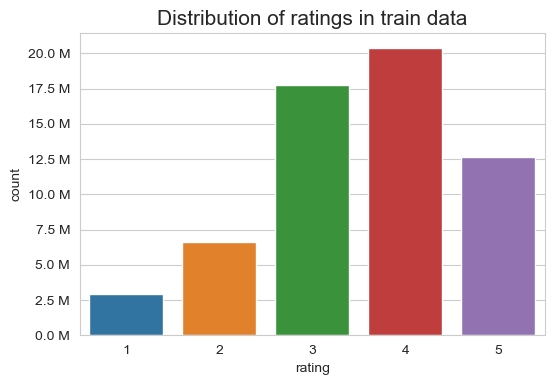

In [8]:
fig, ax1 = plt.subplots(1, 1)
fig.dpi = 100
sns.countplot(train_data.rating)
ax1.set_title('Distribution of ratings in train data', fontdict={'fontsize':15})
ax1.set_yticklabels([human(x, "M") for x in ax1.get_yticks()])
plt.show()

> * Out of the 60M ratings, only 2.5M are 1 rated and 6M are 2 rated.

In [9]:
train_data.date = pd.to_datetime(train_data.date)
train_data['day'] = train_data.date.dt.weekday_name

<h3> 3.3.1 Number of Ratings per Month </h3>

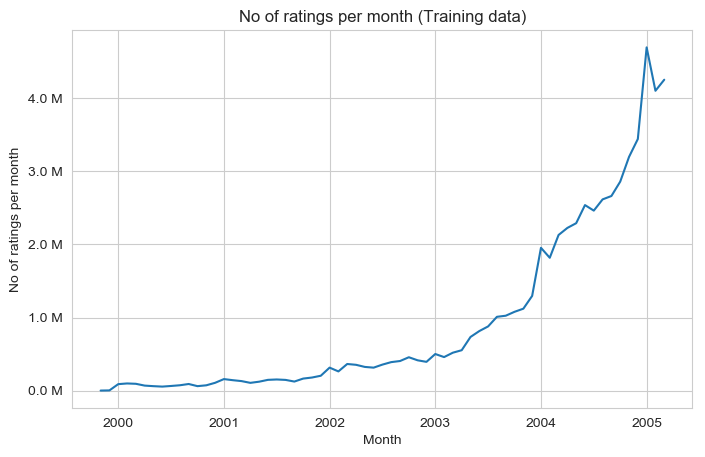

In [10]:
plt.figure(dpi=100, figsize=(8, 5))
ax = train_data.resample("m", on='date')['rating'].count().plot()
ax.set_title('No of ratings per month (Training data)')
ax.set_xlabel('Month')
ax.set_ylabel('No of ratings per month')
ax.set_yticklabels([human(item, "M") for item in ax.get_yticks()])
plt.show()

> * The number of ratings are on a huge rise since 2003.

<h3> 3.3.2 Analysis on the Ratings given by user </h3>

In [12]:
num_rated_movies_per_user = train_data.groupby('user_id')['rating'].count().sort_values(ascending=False)

In [13]:
num_rated_movies_per_user.head()

user_id
305344     15998
2439493    14733
387418     14124
1639792     9748
1932594     7398
Name: rating, dtype: int64

Text(0.5, 0, 'Num of ratings per user')

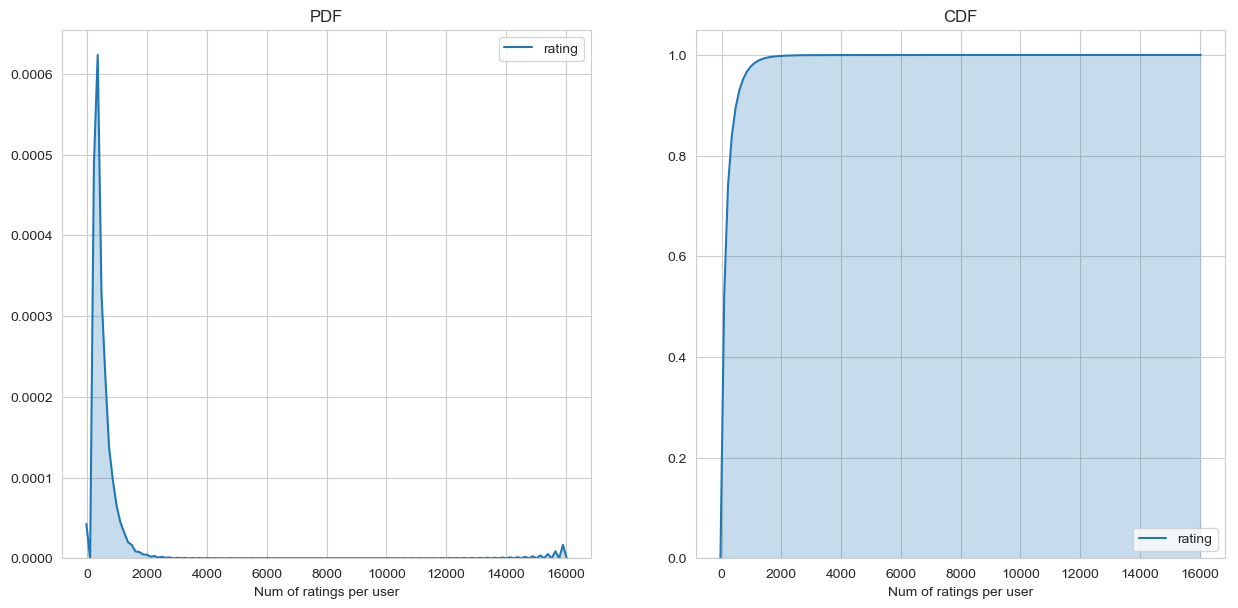

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=100, figsize=(15, 7))

sns.kdeplot(num_rated_movies_per_user, ax=ax1, shade=True)
ax1.set_title('PDF')
ax1.set_xlabel('Num of ratings per user')

sns.kdeplot(num_rated_movies_per_user, ax=ax2, shade=True, cumulative=True)
ax2.set_title('CDF')
ax2.set_xlabel('Num of ratings per user')

> * There are a small number of users who have rated high number of movies.<br>
> * 99% of the ratings are from top 2000 users.

In [15]:
num_rated_movies_per_user.describe()

count    328767.000000
mean        183.376993
std         276.787794
min           1.000000
25%          26.000000
50%          81.000000
75%         226.000000
max       15998.000000
Name: rating, dtype: float64

> * A user has rated 183 movies on average.<br>
> * 25% of users have atleast rated 26 movies.

In [16]:
quantiles = num_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

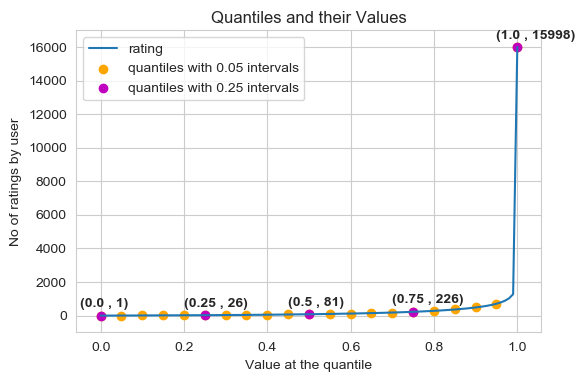

In [17]:
plt.figure(dpi=100)
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')

plt.show()

In [18]:
quantiles[::5]

0.00        1
0.05        4
0.10        9
0.15       15
0.20       20
0.25       26
0.30       33
0.35       42
0.40       53
0.45       66
0.50       81
0.55      100
0.60      122
0.65      149
0.70      183
0.75      226
0.80      284
0.85      364
0.90      486
0.95      707
1.00    15998
Name: rating, dtype: int64

In [19]:
print(f"Num of ratings in at last 5 percentile : {(num_rated_movies_per_user >= 707).sum()}")

Num of ratings in at last 5 percentile : 16464


<h3> 3.3.3 Analysis of ratings of a movie given by a user </h3>

In [20]:
num_ratings_per_movie = train_data.groupby(by='movie_id')['rating'].count().sort_values(ascending=False)

In [21]:
num_ratings_per_movie.head()

movie_id
15124    135103
5317     128127
1905     125718
6287     114695
14313    108095
Name: rating, dtype: int64

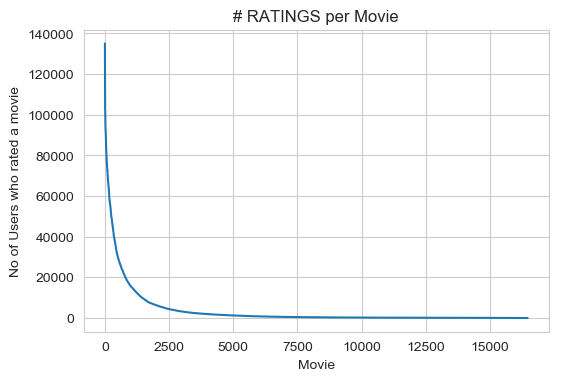

In [22]:
fig = plt.figure(dpi=100)
plt.plot(num_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
plt.show()

> * It is very skewed.. just like number of ratings given by a user.<br>
> * There are some movies (which are very popular) which are rated by huge number of users.<br>
> * But most of the movies(like 90%) got some hundereds of ratings.<br>

<h3> 3.3.4 Number of ratings on each day of the week</h3>

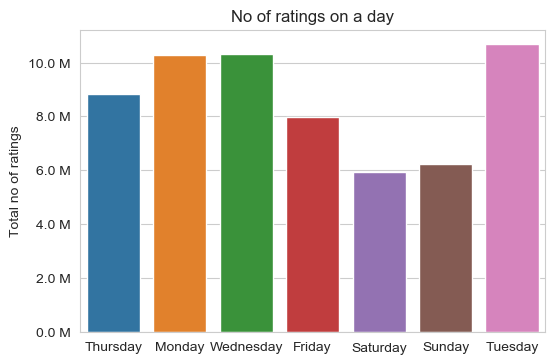

In [23]:
fig, ax1 = plt.subplots(1, 1, dpi=100)
sns.countplot(x='day', data=train_data, ax=ax1)
plt.title('No of ratings on a day')
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax1.set_yticklabels([human(item, "M") for item in ax1.get_yticks()])
plt.show()

> * The number of ratings take a dip on weekends probably due to watching!

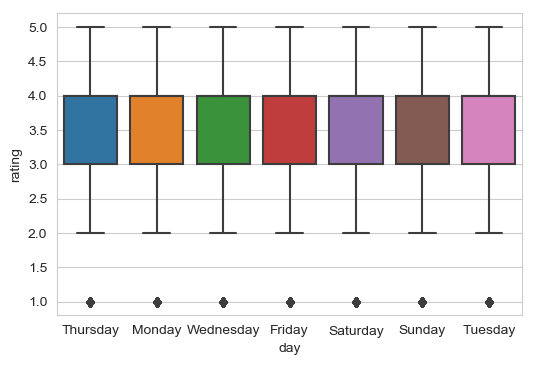

In [24]:
fig = plt.figure(dpi=100)
sns.boxplot(y='rating', x='day', data=train_data)
plt.show()

> * The average rating on any day is 3.5

<h3> 3.3.5 Creating sparse matrix from train_data </h3>

* It'll be very convinient to store the data in a matrix. The matrix contains users as rows and movies as columns.
* Each cell represents the rating of that movie column rated by the user in that row.
* As the number of movies rated by a user are very small, We can store the train_data in a sparse format. This saves a lot of space.

In [27]:
start = datetime.now()

if not os.path.isfile("train_sparse_matrix.npz"):
    train_sparse_matrix = csr_matrix((train_data.rating.values, (train_data.user_id.values, train_data.movie_id.values)))
    sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
else:
    print('Loading from Disk...\n')
    train_sparse_matrix = sparse.load_npz("train_sparse_matrix.npz")
    print('Done..')

print(f'processed in {datetime.now() - start}')

Loading from Disk...

Done..
processed in 0:00:02.738511


__SPARSITY OF THE SPARSE MATRIX__

In [28]:
print(f"shape of the sparse matrix : {train_sparse_matrix.get_shape()}")

u, m = train_sparse_matrix.get_shape()

print(f"sparsity of the sparse_matrix : {(1 - train_sparse_matrix.count_nonzero()/(u*m)) * 100 : .2f}%")

shape of the sparse matrix : (2649430, 17771)
sparsity of the sparse_matrix :  99.87%


__CREATE SPARSE MATRICES FOR CV, TEST__

In [29]:
start = datetime.now()

if not os.path.isfile('cv_sparse_matrix.npz'):
    cv_sparse_matrix = csr_matrix((cv_data.rating.values, (cv_data.user_id.values, cv_data.movie_id.values)))
    sparse.save_npz("cv_sparse_matrix.npz", cv_sparse_matrix)
else:
    print('Loading from Disk...')
    cv_sparse_matrix = sparse.load_npz("cv_sparse_matrix.npz")
    
if not os.path.isfile('test_sparse_matrix.npz'):
    test_sparse_matrix = csr_matrix((test_data.rating.values, (test_data.user_id.values, test_data.movie_id.values)))
    sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
else:
    print('Loading from Disk...')
    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')

print(f'processed in {datetime.now() - start}')

Loading from Disk...
Loading from Disk...
processed in 0:00:02.145575


<h3>3.3.6 Finding Averages</h3>

__GLOBAL AVERAGE OF ALL MOVIE RATINGS__

In [30]:
train_averages = {}
global_avg = train_sparse_matrix.sum() / train_sparse_matrix.count_nonzero()
train_averages['global'] = global_avg
print(f"Global avg of all movie ratings : { global_avg : .3f}")

Global avg of all movie ratings :  3.552


__AVERAGE RATING OF USER, MOVIE__

In [31]:
def get_avg_ratings(sparse_matrix, of='user'):
    
    # if users avg over rows, else cols
    ax = 1 if of == 'user' else 0
    sum_ratings = sparse_matrix.sum(axis=ax).A1
    num_ratings = (sparse_matrix != 0).sum(axis=ax).A1
    
    avg_ratings = sum_ratings / num_ratings #avg
    u, m = sparse_matrix.shape
    avg_ratings = {i : sum_ratings[i] / num_ratings[i] 
            for i in range(len(num_ratings)) 
            if num_ratings[i] != 0}
    #avg_ratings[np.isnan(avg_ratings)] = 0  #nan to zero
    #avg_ratings = dict(zip(range(len(avg_ratings)), avg_ratings))
    
    return avg_ratings

In [32]:
train_averages['user'] = get_avg_ratings(train_sparse_matrix, 'user')
print(f"average rating given by user 10 : {train_averages['user'][10] : 3f}")

average rating given by user 10 :  3.384615


In [33]:
train_averages['movie'] = get_avg_ratings(train_sparse_matrix, 'movie')
print(f"average rating of movie 15 : {train_averages['movie'][15] : 3f}")

average rating of movie 15 :  3.266055


<h3> 3.3.7 Distributions of Avg Ratings of Users & Movies in Train Data </h3>

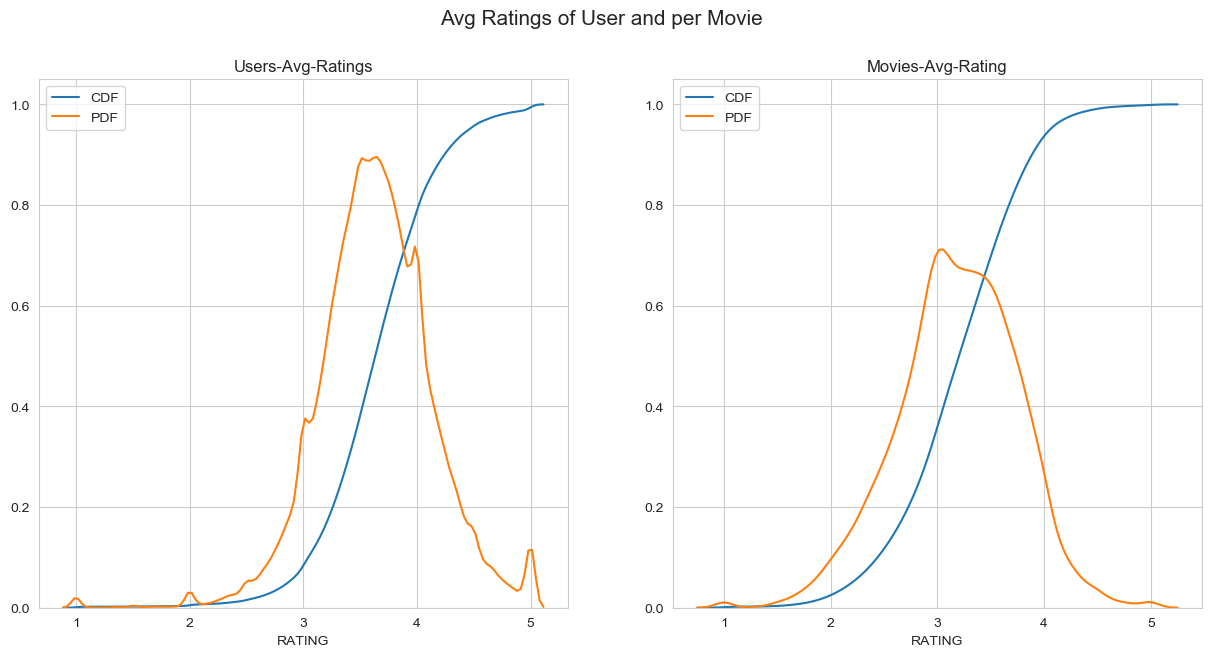

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, dpi=100, figsize=(15, 7))
fig.suptitle('Avg Ratings of User and per Movie', fontsize=15)

ax1.set_title('Users-Avg-Ratings')
ax1.set_xlabel("RATING")
# get the list of average user ratings from the averages dictionary..
user_averages = list(train_averages['user'].values())
sns.distplot(user_averages, ax=ax1, hist=False, 
             kde_kws=dict(cumulative=True), label='CDF')
sns.distplot(user_averages, ax=ax1, hist=False,label='PDF')

ax2.set_title('Movies-Avg-Rating')
ax2.set_xlabel("RATING")
# get the list of movie_average_ratings from the dictionary..
movie_averages = list(train_averages['movie'].values())
sns.distplot(movie_averages, ax=ax2, hist=False, 
             kde_kws=dict(cumulative=True), label='CDF')
sns.distplot(movie_averages, ax=ax2, hist=False, label='PDF')
plt.show()

### 3.3.8 <font color='red'>Cold Start Problem</font>

__USERS__

In [37]:
num_users_train = train_data.user_id.unique().shape[0]
new_users = num_users - num_users_train
print(f"Total number of users                   : {num_users}")
print(f"Total number of users in train_data     : {num_users_train}")
print(f"Total number of new users(not in train) : {new_users}({new_users*100/num_users :.2f}%)")

Total number of users                   : 480189
Total number of users in train_data     : 328767
Total number of new users(not in train) : 151422(31.53%)


> * There are 31.5% new users in cv/test who aren't present in train.
> * This is because of the splits and the number is quite high.
> * We need to handle 151422 new users who didn't appear in train_data.

__MOVIES__

In [38]:
num_movies_train = train_data.movie_id.unique().shape[0]
new_movies = num_movies - num_movies_train
print(f"Total number of movies                   : {num_movies}")
print(f"Total number of movies in train_data     : {num_movies_train}")
print(f"Total number of new movies(not in train) : {new_movies}({new_movies*100/num_movies :.2f}%)")

Total number of movies                   : 17770
Total number of movies in train_data     : 16464
Total number of new movies(not in train) : 1306(7.35%)


> * We need to handle 1306 movies that haven't appeared in the train_data.

<h2> 3.4 Computing Similarity matrices </h2>

<h3> 3.4.1 Computing User-User Similarity matrix </h3>

* We have __405,041 users__ with us in training set. Each users is represented by a 17K dim sparse vector

* Calculating User User Similarity_Matrix is __not very easy__(_unless you have huge Computing Power and lots of time_)<br>
because of number of users being large.

* You can try if you want to. Your system could crash or the program stops with **Memory Error**.

* It takes roughly __8.88 sec__ for computing simlilar users for __one user__.

* ${ 405041 \times 8.88 = 3596764.08  \sec } =  59946.068 \min = 999.101133333 \text{ hours} = 41.6292 \text{ days}...$

* Even if we run on 4 cores parallelly (a typical system now a days), It will still take almost __10 and 1/2__ days.
    
__SVD__

* The train data was reduced to 500 dim using SVD

* It takes almost __12.18 sec__ for computing simlilar users for __one user__.
    
* We have __405041 users__ with us in training set.


* ${ 405041 \times 12.18 = 4933399.38 \sec } =  82223.323 \min = 1370.388716667 \text{ hours} = 57.0995 \text{ days}...$

* Even we run on 4 cores parallelly (a typical system now a days), It will still take almost __14 to 15__ days.


<font color='red'>__WHY DID THIS HAPPEN?__</font>

* The time required for computing the similarity in case of SVD, because of the __dense__ representation of the vector.<br>
whereas the original 17K dim vector was a __sparse__ one, so only cells with values are considered this reduced computation time.

<font color='GREEN'>__THEN HOW DO WE COMPUTE THE SIMILARITY?__</font>

* An alternative way is to compute the user similarity for a user whenever required (ie,. __Run Time__)

* We'll maintain a boolean vector which stores whether the similarity is computed for a user.<br>
and a dictionary for storing the computed similarities.
    - If a user isn't found in the dict, we'll compute similarities to get (say top 1000) most similar users and add them to dict.
    - If the user is already found in the dict, we'll just retreive the similarities.
    
*  __key    :__ _userid_ <br>
   __value  :__ _Again a dictionary(sub-dict)_ <br>
   **Sub-dict**<br>
   __key    :__ _Similar User_<br>
   __value  :__ _Similarity Value_ <br>
   
* Example : 
<pre>{20: {233  : 0.2,
           1056 : 0.19}}</pre>             

<h3> 3.4.2 Computing Movie-Movie Similarity matrix </h3>

In [39]:
start = datetime.now()
if not os.path.isfile('movie_similarities.npz'):
    mov_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
    print("Done..")
    # store this sparse matrix in disk before using it. For future purposes.
    sparse.save_npz("movie_similarities.npz", mov_sim_sparse)
else:
    print('Loading from Disk...')
    mov_sim_sparse = sparse.load_npz('movie_similarities.npz')
print(f"processed in {datetime.now() - start}")

Loading from Disk...
processed in 0:00:56.148319


In [40]:
print(f"shape of the similarity matrix : {mov_sim_sparse.shape}")

shape of the similarity matrix : (17771, 17771)


> * Above we a sparse matrix in which each row stores 17K similarities.
> * We'll only store the top similar movies and discard the rest


In [41]:
movie_ids = np.unique(mov_sim_sparse.nonzero()[1])

__STORING IN A DICT__

In [42]:
start = datetime.now()

similar_movies_dict = {}

for movie in movie_ids:
    similar_movies_dict[movie] = mov_sim_sparse[movie].toarray().ravel().argsort()[::-1][1 : 101]

print(f"processed in {datetime.now() - start}")

processed in 0:00:24.535044


In [43]:
print(f"Top 10 movies of movie_id 15 : {similar_movies_dict[15][:10]}")

Top 10 movies of movie_id 15 : [ 8013 16528  3755 12049  8279 13105  5927  4424  9071  4549]


<h3> 3.4.3 Finding most similar movies using similarity matrix </h3>

* Let's see if the similarity of movies works as expected!!!

In [44]:
# First Let's load the movie details into soe dataframe..
# movie details are in 'netflix/movie_titles.csv'

movie_titles = pd.read_csv("movie_titles.csv", sep=',', header = None,
                           names=['movie_id', 'year_of_release', 'title'],
                           index_col = 'movie_id', encoding = "ISO-8859-1")

movie_titles.head()

,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


__SIMILAR MOVIES__

In [45]:
movie_id = 67

print(f"\n Movie             ==> {movie_titles.loc[movie_id].values[1]}")
print(f"\n Year of Release   ==> {movie_titles.loc[movie_id].values[0]}")
print(f"\n Number of ratings ==> {train_sparse_matrix[:, movie_id].getnnz()} ratings")
print(f"\n ===================== TOP 10 SIMILAR MOVIES =====================")
movie_titles.loc[similar_movies_dict[movie_id][:10]]


 Movie             ==> Vampire Journals

 Year of Release   ==> 1997.0

 Number of ratings ==> 239 ratings

 ===================== TOP 10 SIMILAR MOVIES =====================


,year_of_release,title
movie_id,,
323,1999.0,Modern Vampires
4044,1998.0,Subspecies 4: Bloodstorm
1688,1993.0,To Sleep With a Vampire
1900,1997.0,Club Vampire
16279,2002.0,Vampires: Los Muertos
12053,1993.0,Dracula Rising
13962,2001.0,Dracula: The Dark Prince
4667,1996.0,Vampirella
13873,2001.0,The Breed


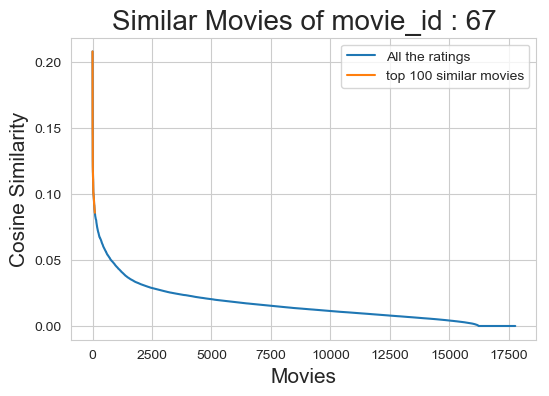

In [46]:
movie_similarities = mov_sim_sparse[movie_id].toarray().ravel()
movie_sim_idxs = movie_similarities.argsort()[::-1][1:]

plt.figure(dpi=100)
plt.plot(movie_similarities[movie_sim_idxs], label='All the ratings')
plt.plot(movie_similarities[movie_sim_idxs[:100]], label='top 100 similar movies')
plt.title(f"Similar Movies of movie_id : {movie_id}", fontsize=20)
plt.xlabel("Movies", fontsize=15)
plt.ylabel("Cosine Similarity", fontsize=15)
plt.legend()
plt.show()

>  *__In the same way, we can find the similarity between users.__*

__SIMILAR USERS__

In [47]:
user_id = 470
movies_rated = train_sparse_matrix[user_id].nonzero()[1]
print(f"\n Number of movies rated by user_id  {user_id} : {movies_rated.shape[0]}")
user_sim = cosine_similarity(train_sparse_matrix[user_id], train_sparse_matrix).ravel()
sim_user_idxs = user_sim.argsort()[::-1][1:6]


 Number of movies rated by user_id  470 : 32


__user__

In [48]:
movie_titles.loc[movies_rated[:5]]

,year_of_release,title
movie_id,,
313,2000.0,Pay It Forward
483,2001.0,Rush Hour 2
1145,2001.0,The Wedding Planner
1542,1993.0,Sleepless in Seattle
1798,1987.0,Lethal Weapon


__similar user1__

In [49]:
movie_titles.loc[train_sparse_matrix[sim_user_idxs[0]].nonzero()[1][:5]]

,year_of_release,title
movie_id,,
313,2000.0,Pay It Forward
1145,2001.0,The Wedding Planner
1428,2003.0,The Recruit
1542,1993.0,Sleepless in Seattle
1975,2000.0,Hollow Man


__similar user2__

In [50]:
movie_titles.loc[train_sparse_matrix[sim_user_idxs[1]].nonzero()[1][:5]]

,year_of_release,title
movie_id,,
1145,2001.0,The Wedding Planner
1307,2003.0,S.W.A.T.
1542,1993.0,Sleepless in Seattle
1798,1987.0,Lethal Weapon
3638,2003.0,Bad Boys II


<font color='red'>__Please open the next notebook__</font>